In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.datasets import make_blobs, load_wine

from data_functions import load_data
from error_probs_model import ErrorProbsModel
from parzen_window_classifier import PWC

from functools import partial

from calibration import get_calibration_errors, get_ece, get_mce
from numpy.random import default_rng

import warnings
from plotting_functions import plot_mean_std

from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import cm
from ipywidgets import interact, IntSlider
rng = default_rng(12345)

In [41]:
def eval_classifier(classifier, X_test, y_test, results):
	
	y_pred = classifier.predict(X_test)
	results['accuracies'].append(np.round(np.sum(y_pred == y_test) / len(y_test), 3))

	results['mce'].append(np.round(get_mce(y_test, y_pred), 3))
	results['ece'].append(np.round(get_ece(y_test, y_pred), 3))
	
def select_fixed_annotator(**kwargs):

	n_instances = kwargs['X_selected'].shape[0]
	annotators = np.zeros(n_instances, dtype=int) + kwargs['annotator']

	return annotators

def select_random_annotator(**kwargs):
	
	y_DL = kwargs['y_DL']
	selected_idx = kwargs['X_selected']
	n_annotators = y_DL.shape[1]
	n_instances = selected_idx.shape[0]

	annotators = []
	selected_y = y_DL[selected_idx]
	if 0 in np.sum(np.isnan(selected_y), axis = 1):
		print("hhh")
	for i in range(n_instances):
		annotators.append(rng.choice(np.where(np.isnan(selected_y[i]))[0]))
		
	return annotators

def select_annotator_epm(**kwargs):
	
	X_train = kwargs['X_train']
	selected_idx = kwargs['X_selected']
	y_DL = kwargs['y_DL']
	epm = ErrorProbsModel(kwargs['n_classes'])
	epm.fit(X_train, y_DL)
	label_accuracy = epm.predict(X_train[selected_idx])

	# prevent same annotator from labeling again
	labels = y_DL[selected_idx]
	label_accuracy[~np.isnan(labels)] = 0.

	annotators = np.argmax(label_accuracy, axis=1)
	return annotators

def selection(n, classifier, query_strategy, annotator_selection, X_train, y_train, y_DL, relabel=True):

	n_classes = len(np.unique(y_train))

	# exclude instances that have an annotation already
	mask = np.sum(~np.isnan(y_DL), axis=1) == 0
	
	if relabel:
		# exclude instances that already have all annotations
		mask = np.sum(~np.isnan(y_DL), axis=1) != y_DL.shape[1]
	instances_idx = query_strategy(n, classifier, X_train, y_DL, mask)
	annotators_idx = annotator_selection(X_train=X_train, X_selected=instances_idx, y_DL=y_DL,
									  	 n_classes=n_classes)
	
	y_DL[instances_idx, annotators_idx] = y_train[instances_idx, annotators_idx]

	return y_DL

def margin_qs(n, classifier, X, y, mask):

	p = classifier.predict_proba(X)
	instances_idx = np.argsort(np.diff(np.sort(p, axis=1))[:,-1])
	instances_idx = np.array([x for x in instances_idx if x not in np.arange(X.shape[0])[~mask]])
	instances_idx = instances_idx[:n]

	if len(instances_idx) != 10:
		print("hello")

	return instances_idx

def initial_choice(y_train, nbudget, n_annotators):

	y_DL = np.empty_like(y_train, dtype=float)
	y_DL[:] = np.nan
	
	# initial choice
	idx = [i for l in [rng.choice(np.where(y_train==c)[0],nbudget,replace=False)
						for c in np.unique(y_train)] for i in l]

	mask = np.zeros_like(y_train, dtype=bool)
	annotators = rng.integers(0, n_annotators, nbudget * len(np.unique(y_train)))

	mask[idx, annotators] = True
	y_DL[mask] = y_train[mask]
	
	return y_DL

def run_experiment(data_set_name, seed, classifier, nbudget=5, query_strategy=margin_qs, 
				   annnotator_selection=select_random_annotator, verbose=False, relabel=True,
				   n_iterations=None):
	
	X, y_true, y = load_data(data_set_name)

	n_classes = len(np.unique(y_true))
	n_instances, n_annotators = y.shape

	budget = nbudget * n_classes

	X_train, X_test, y_train_idx, y_test_idx = train_test_split(X, np.arange(len(y_true)), test_size=0.4, random_state=seed)

	y_train = y[y_train_idx]
	y_test = y_true[y_test_idx]

	y_DL = initial_choice(y_train, nbudget, n_annotators)
	
	# Standardize
	scaler = StandardScaler().fit(X_train)
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)

	if isinstance(classifier, partial) and classifier.func == PWC:
		classifier = classifier(n_classes=n_classes)
	else:
		classifier = classifier()
	if not n_iterations:
		n_iterations = np.minimum(len(X_test) // (budget), 50)
	
	results = {'accuracies': [], 'mce': [], 'ece': [], 'api': [], 'classes' : n_classes,
			 'instances' : n_instances, 'annotators': n_annotators, 'max_annotations': [],
			 'n_annotations' : [np.zeros(240)], 'y_DL': [y_DL.copy()], 'X_train': X_train}

	# AL loop
	for i in range(n_iterations):

		classifier.fit(X_train, y_DL)
		
		eval_classifier(classifier, X_test, y_test, results)

		y_DL = selection(budget, classifier, query_strategy, annnotator_selection, 
				   		 X_train, y_train, y_DL, relabel=relabel)

		n_annotations = np.sum(~np.isnan(y_DL), axis=1)
		results['n_annotations'].append(n_annotations)
		results['max_annotations'].append(np.max(n_annotations))
		mask = n_annotations != 0
		results['api'].append(np.mean(n_annotations[mask]).round(2))
		results['y_DL'].append(y_DL.copy())

		if verbose:
			print(f'Iteration: {i}. Accuracy: {results['accuracies'][-1]}. MCE: {results['mce'][-1]}. ECE: {results['ece'][-1]}')
			print(f'Annotations per instance: {results['api'][-1]}. Max annotations: {results['max_annotations'][-1]}')
			print(np.sum(n_annotations))
	
	return results

Data set: breast-cancer-wisconsin-simulated-y. Simulations: 20
Annotator selection: fixed
Accuracy:0.712. ECE: 0.003. MCE: 0.06
Annotations per instance: 1.0. Max annotations: 1.1


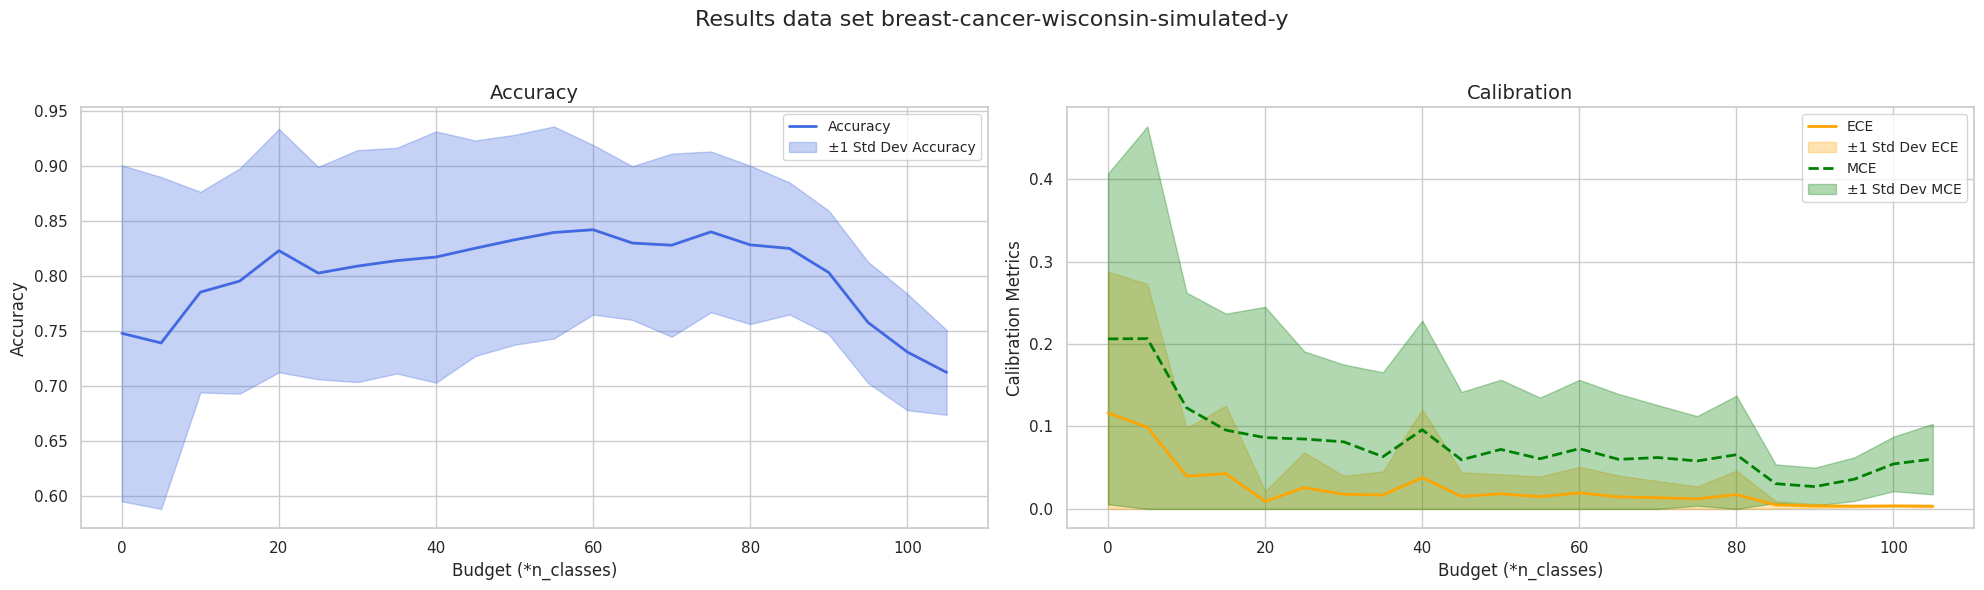

Data set: breast-cancer-wisconsin-simulated-y. Simulations: 20
Annotator selection: random
Accuracy:0.934. ECE: 0.033. MCE: 0.086
Annotations per instance: 2.092. Max annotations: 5.0


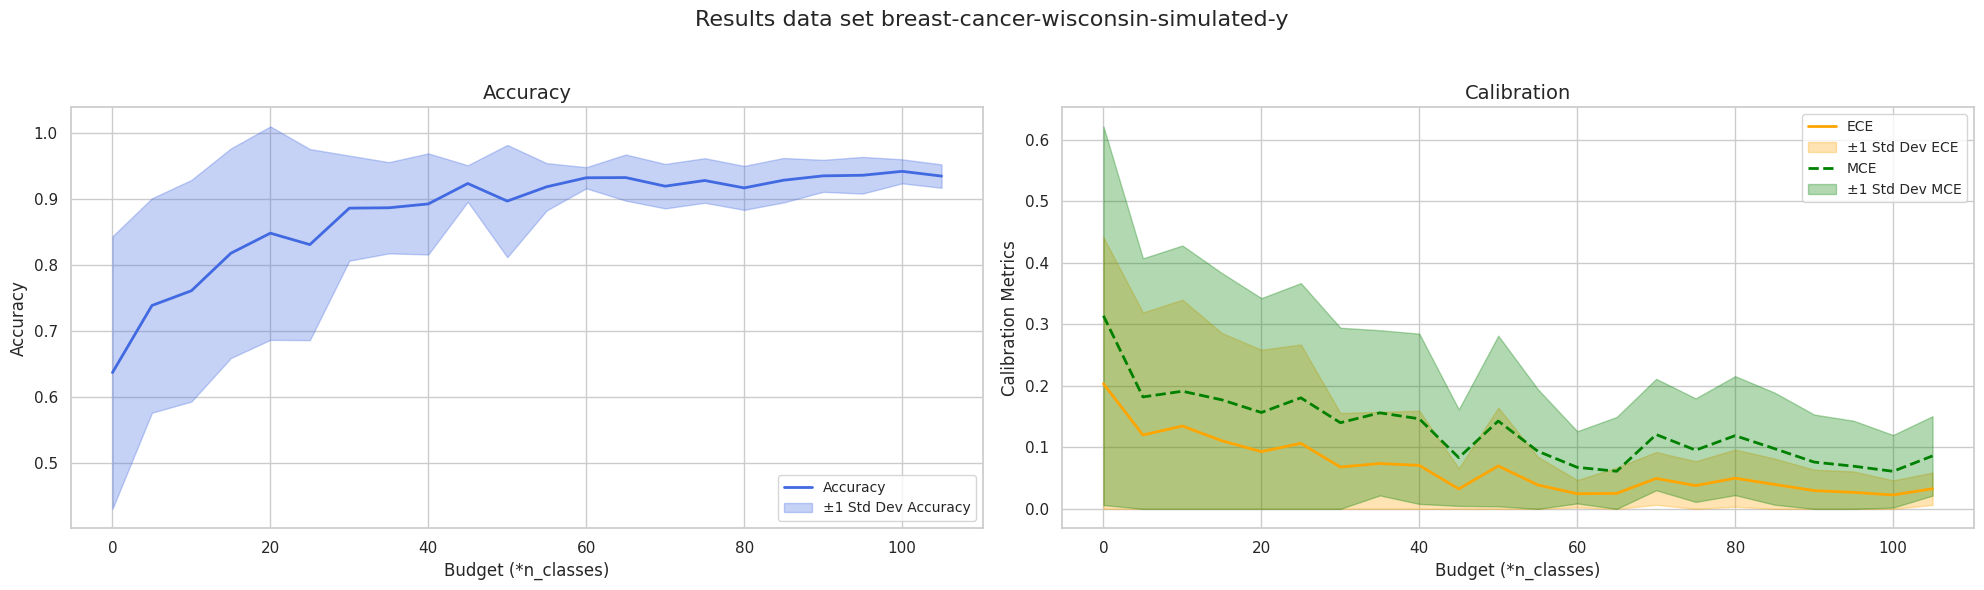

Data set: breast-cancer-wisconsin-simulated-y. Simulations: 20
Annotator selection: epm
Accuracy:0.935. ECE: 0.032. MCE: 0.082
Annotations per instance: 2.045. Max annotations: 5.0


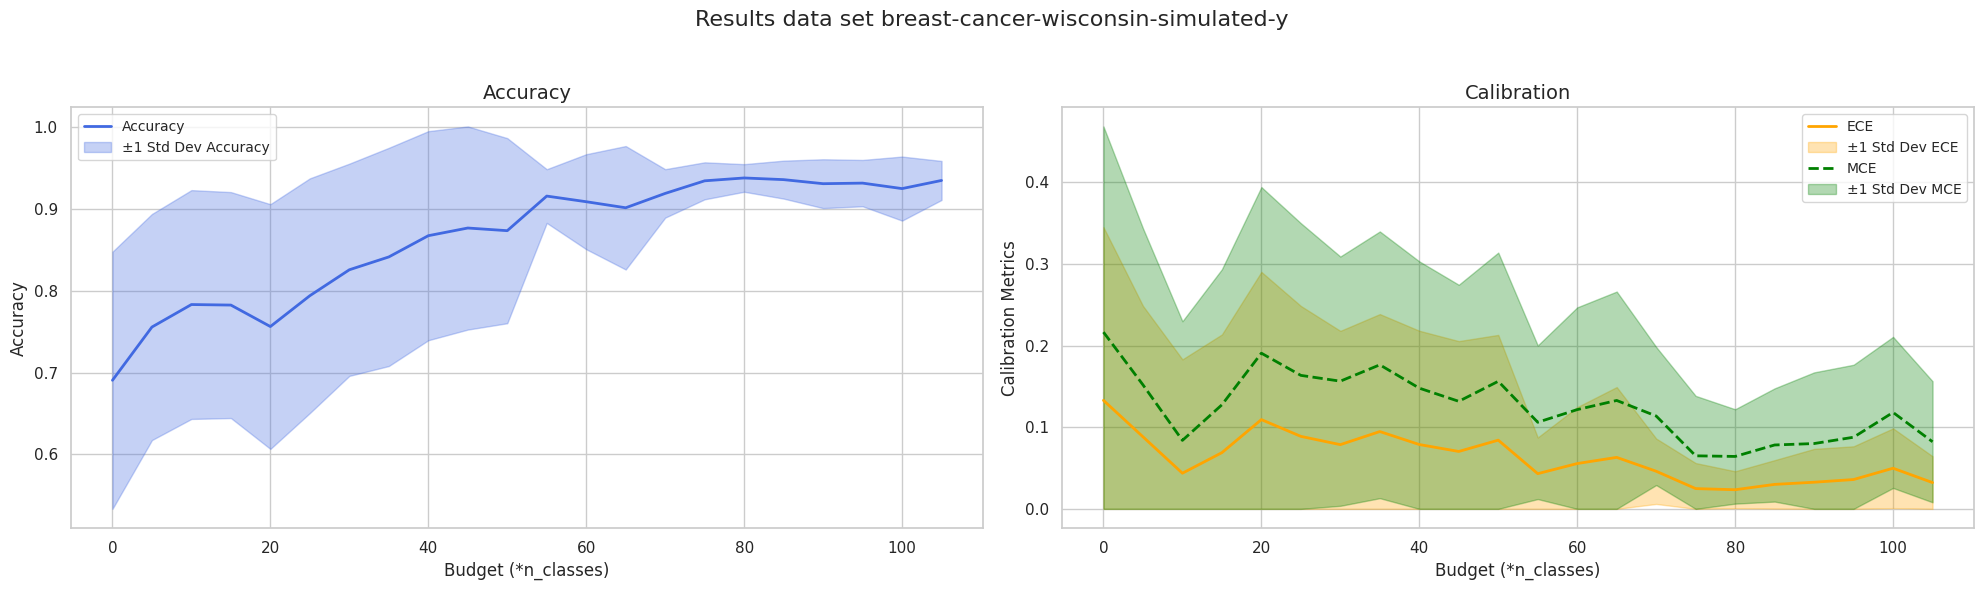

Data set: biodegradation-simulated-y. Simulations: 20
Annotator selection: fixed
Accuracy:0.737. ECE: 0.011. MCE: 0.099
Annotations per instance: 1.0. Max annotations: 1.05


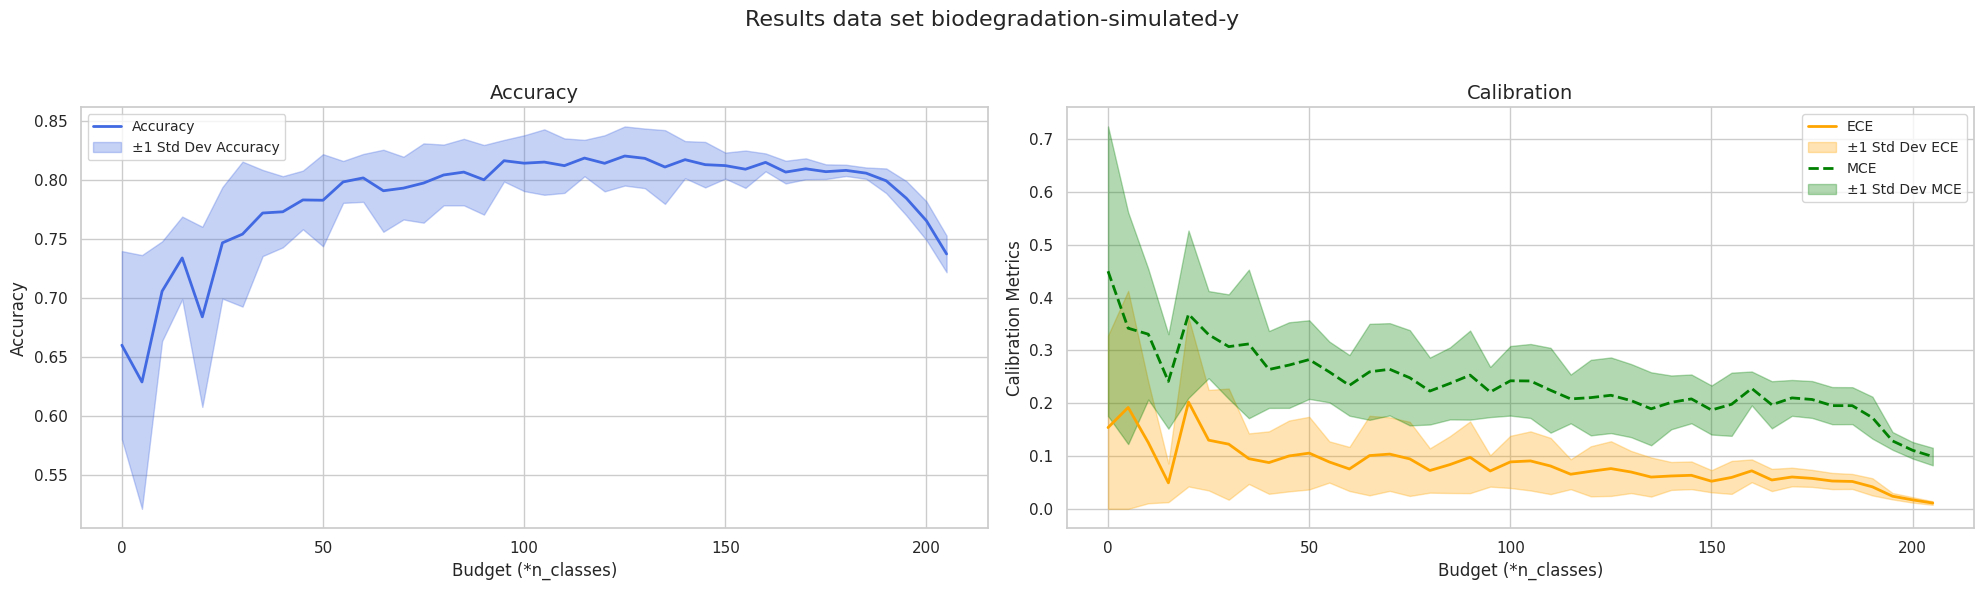

Data set: biodegradation-simulated-y. Simulations: 20
Annotator selection: random
Accuracy:0.811. ECE: 0.064. MCE: 0.216
Annotations per instance: 1.707. Max annotations: 5.0


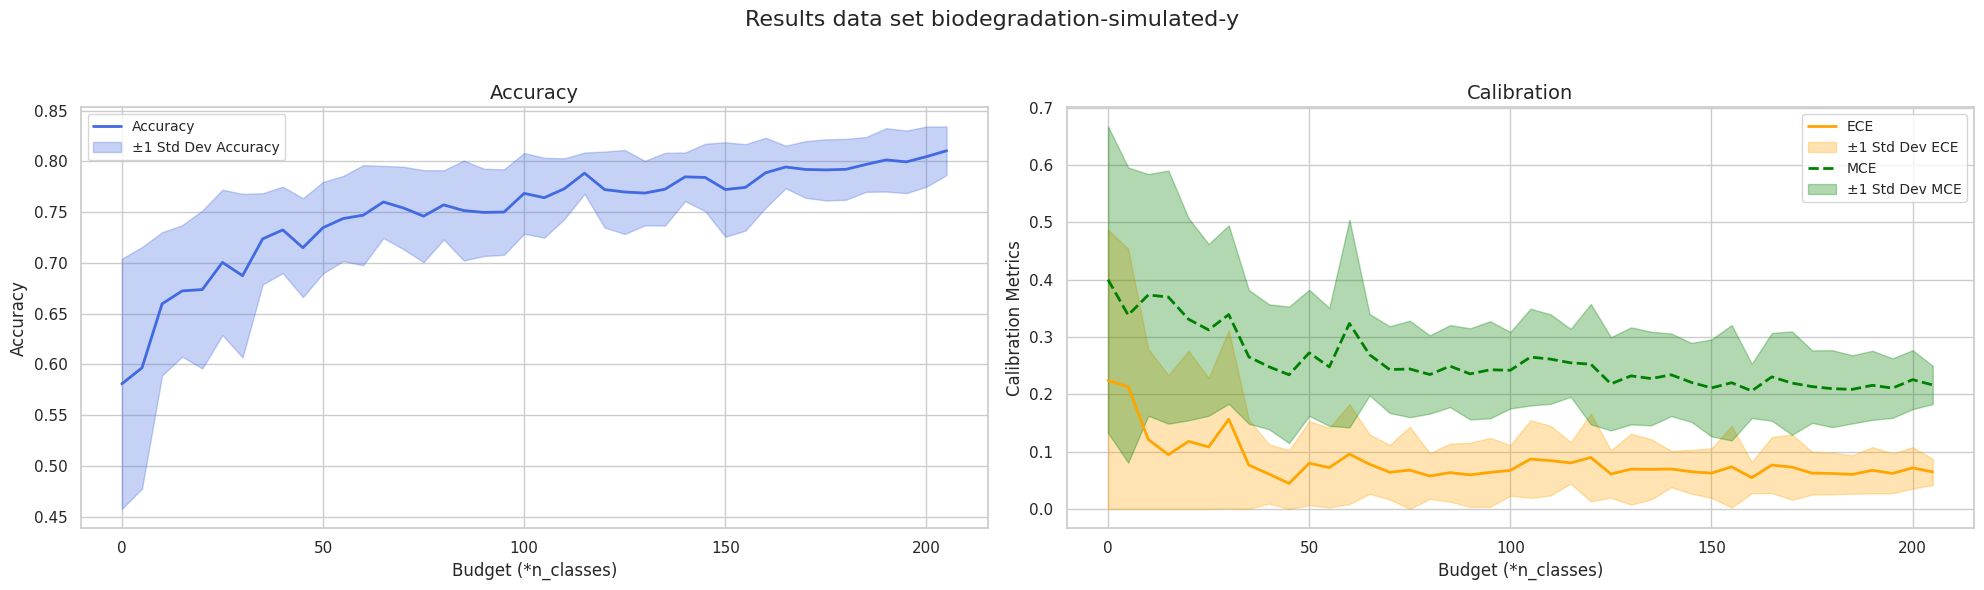

Data set: biodegradation-simulated-y. Simulations: 20
Annotator selection: epm
Accuracy:0.8. ECE: 0.083. MCE: 0.235
Annotations per instance: 1.727. Max annotations: 4.95


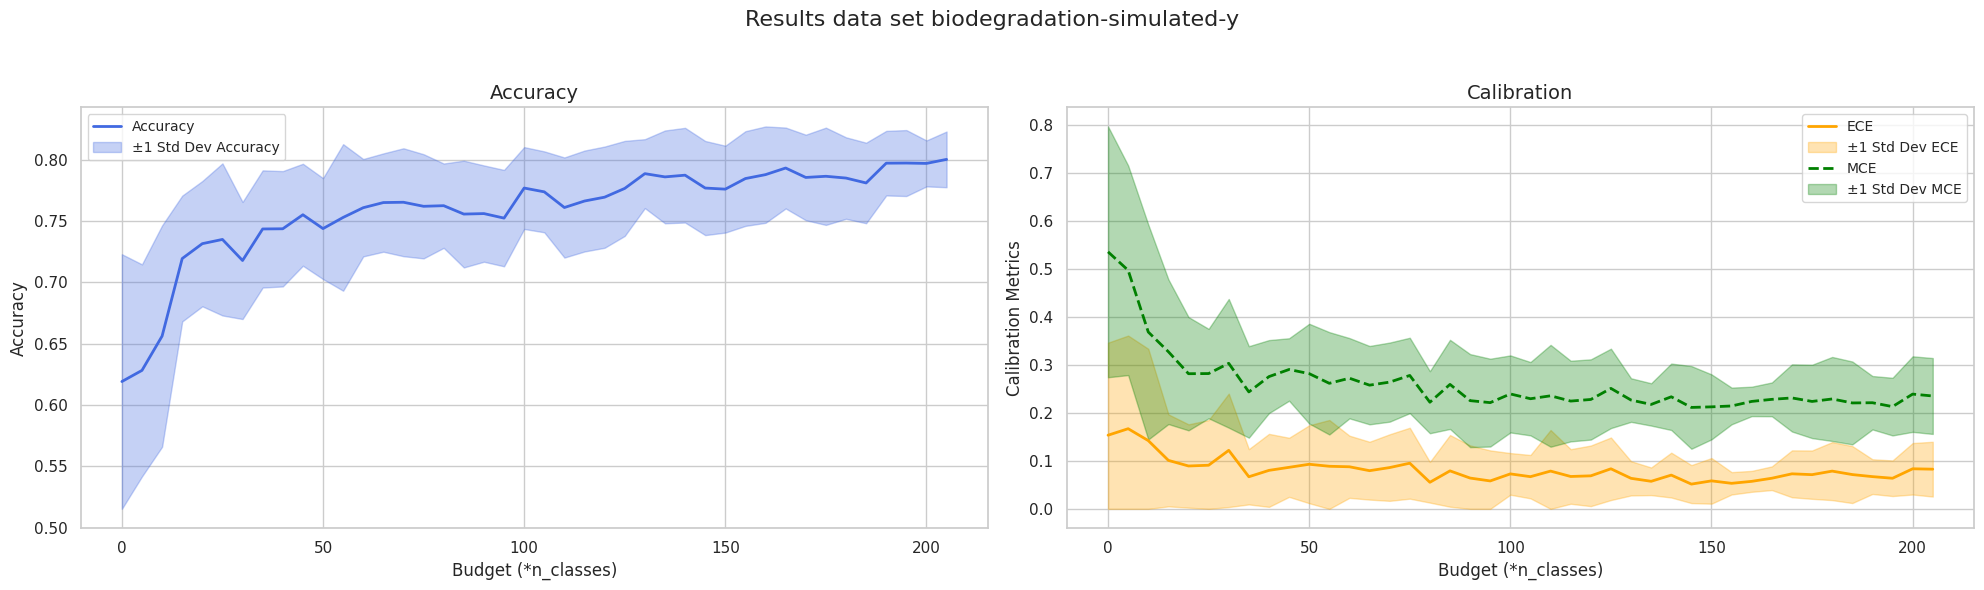

Data set: banknote-simulated-y. Simulations: 20
Annotator selection: fixed
Accuracy:0.947. ECE: 0.053. MCE: 0.109
Annotations per instance: 1.0. Max annotations: 1.0


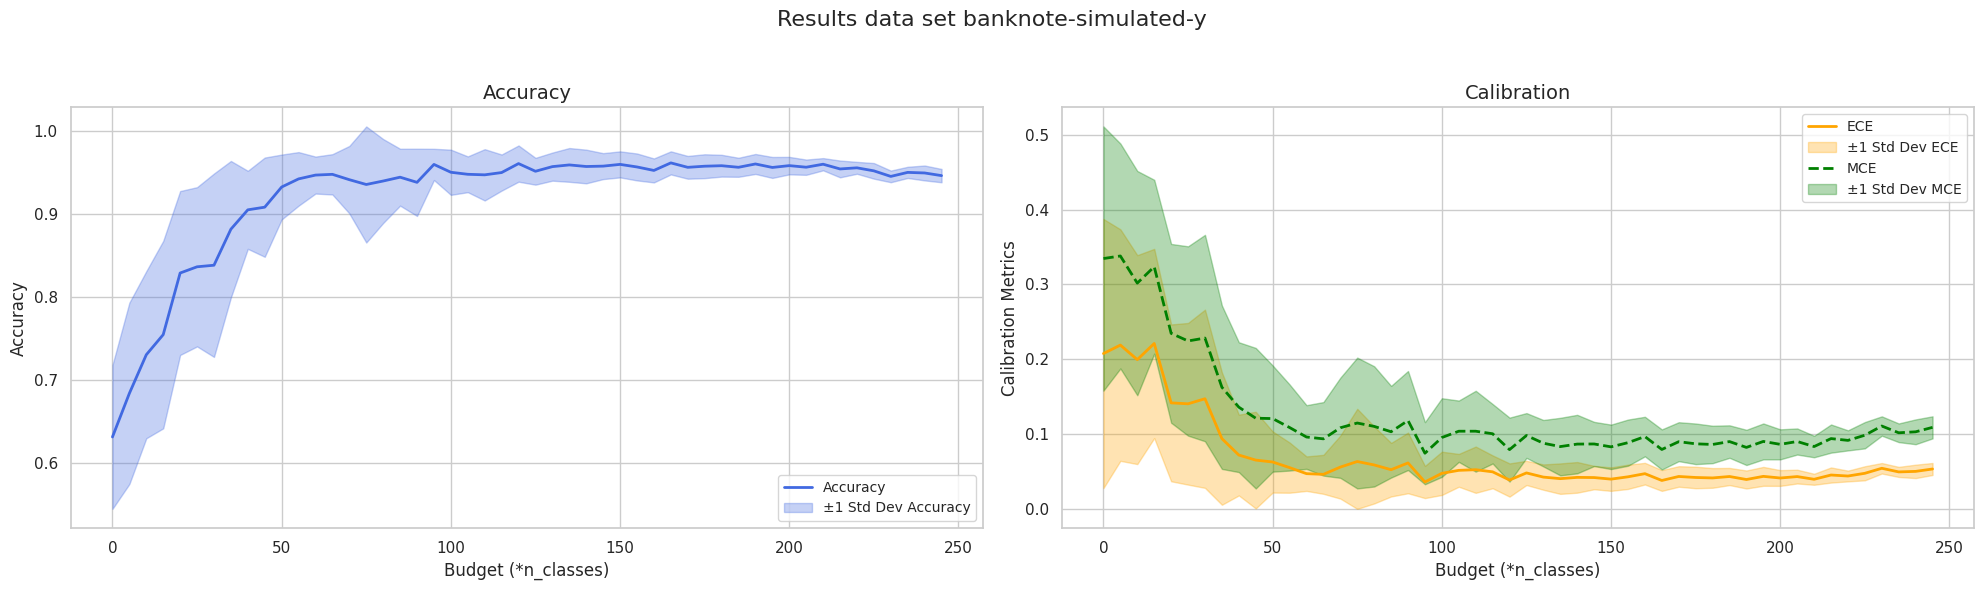

Data set: banknote-simulated-y. Simulations: 20
Annotator selection: random
Accuracy:0.984. ECE: 0.016. MCE: 0.035
Annotations per instance: 2.339. Max annotations: 5.0


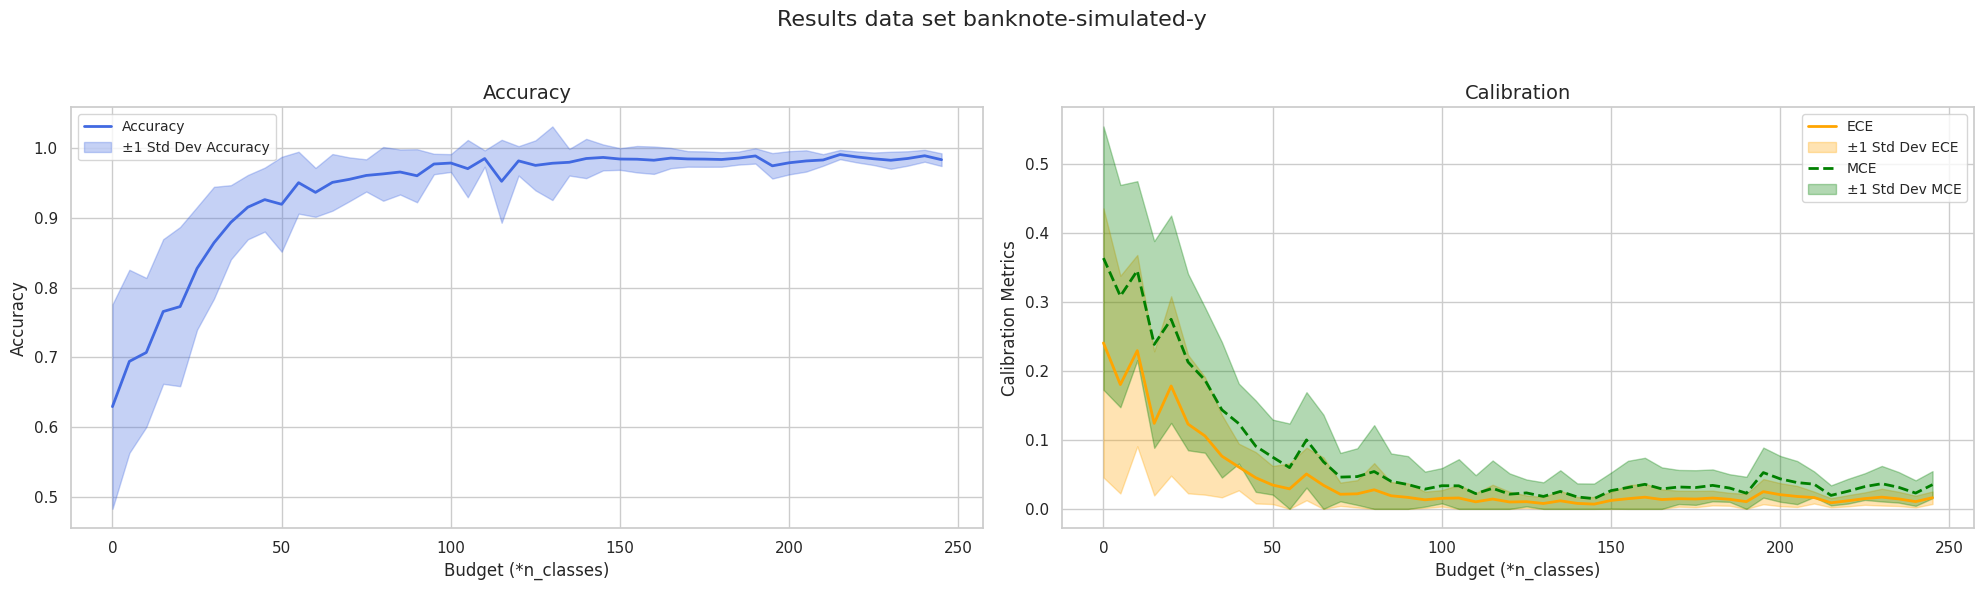

Data set: banknote-simulated-y. Simulations: 20
Annotator selection: epm
Accuracy:0.988. ECE: 0.012. MCE: 0.027
Annotations per instance: 2.33. Max annotations: 5.0


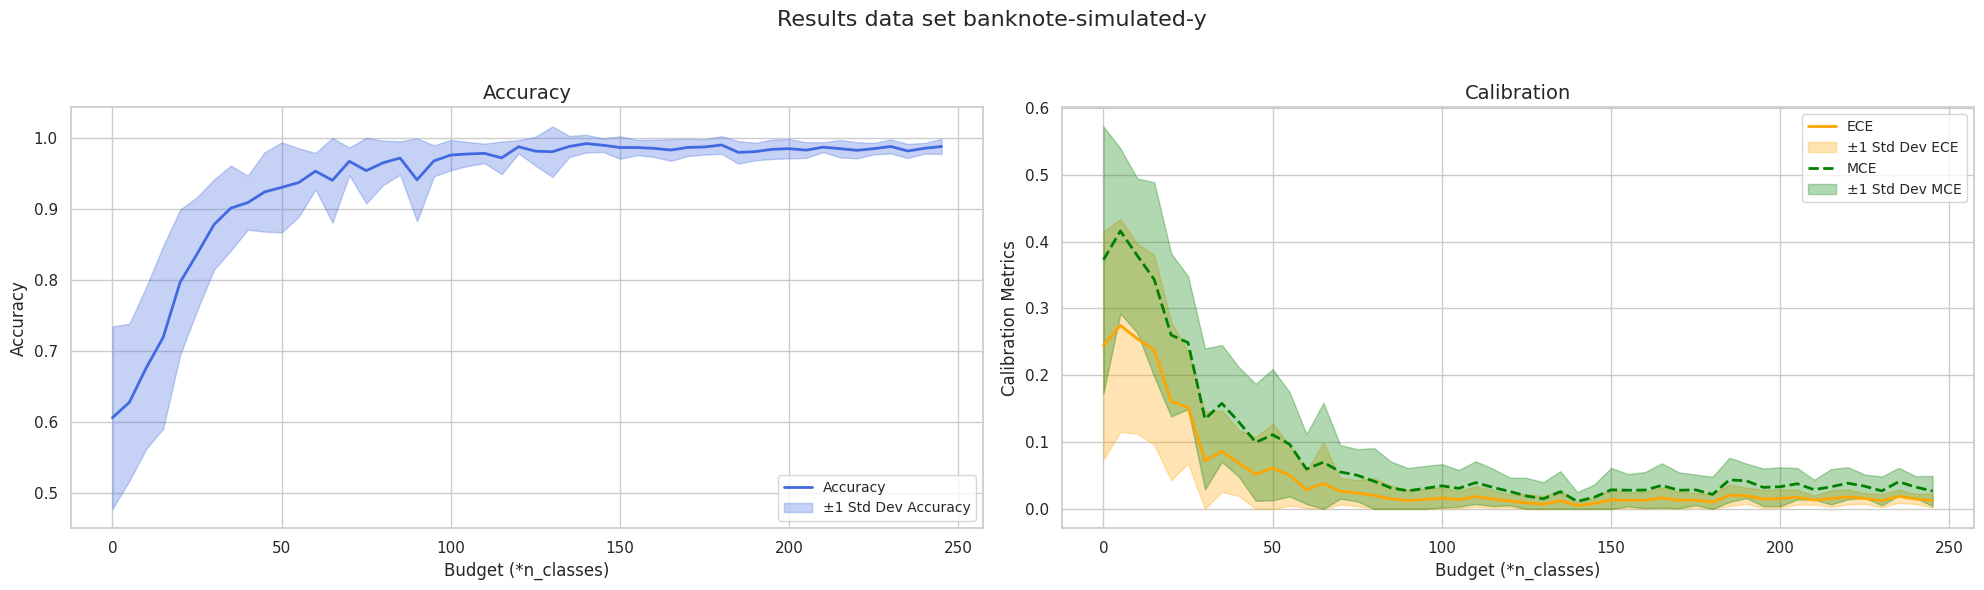

Data set: steel-plates-fault-simulated-y. Simulations: 20
Annotator selection: fixed
Accuracy:0.491. ECE: 0.485. MCE: 0.603
Annotations per instance: 1.0. Max annotations: 1.0


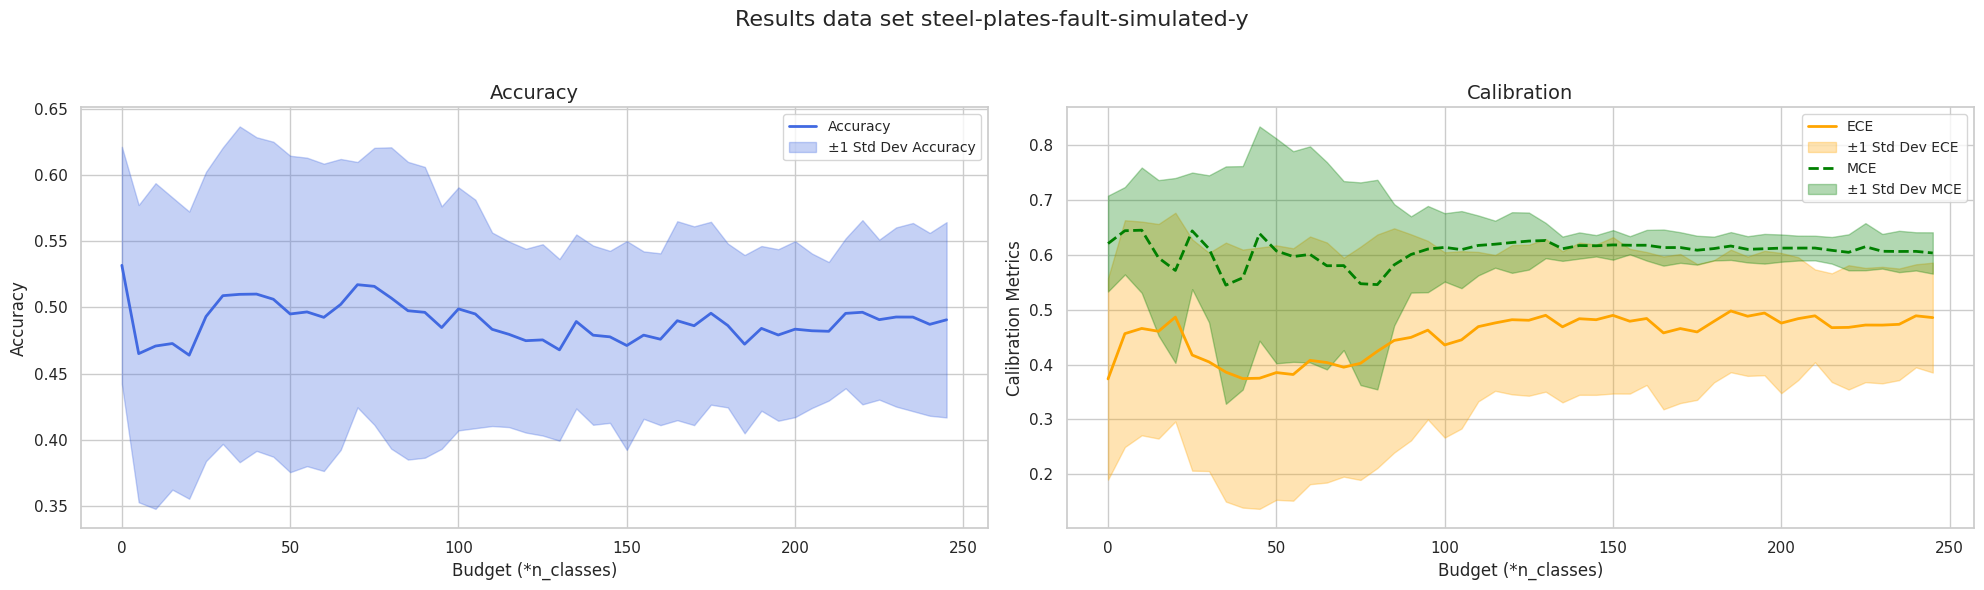

Data set: steel-plates-fault-simulated-y. Simulations: 20
Annotator selection: random
Accuracy:0.765. ECE: 0.229. MCE: 0.384
Annotations per instance: 1.523. Max annotations: 4.9


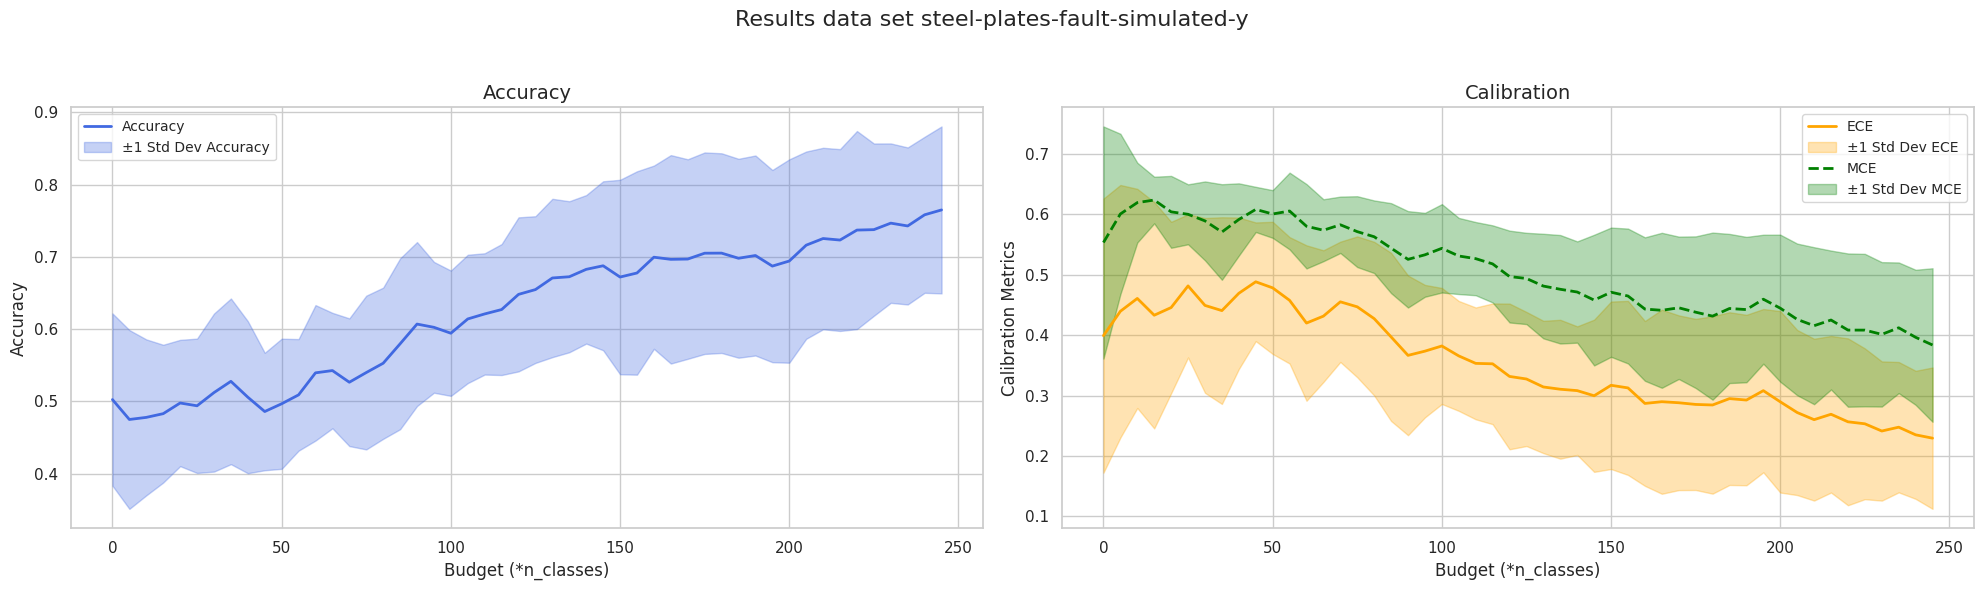

Data set: steel-plates-fault-simulated-y. Simulations: 20
Annotator selection: epm
Accuracy:0.738. ECE: 0.25. MCE: 0.404
Annotations per instance: 1.542. Max annotations: 4.8


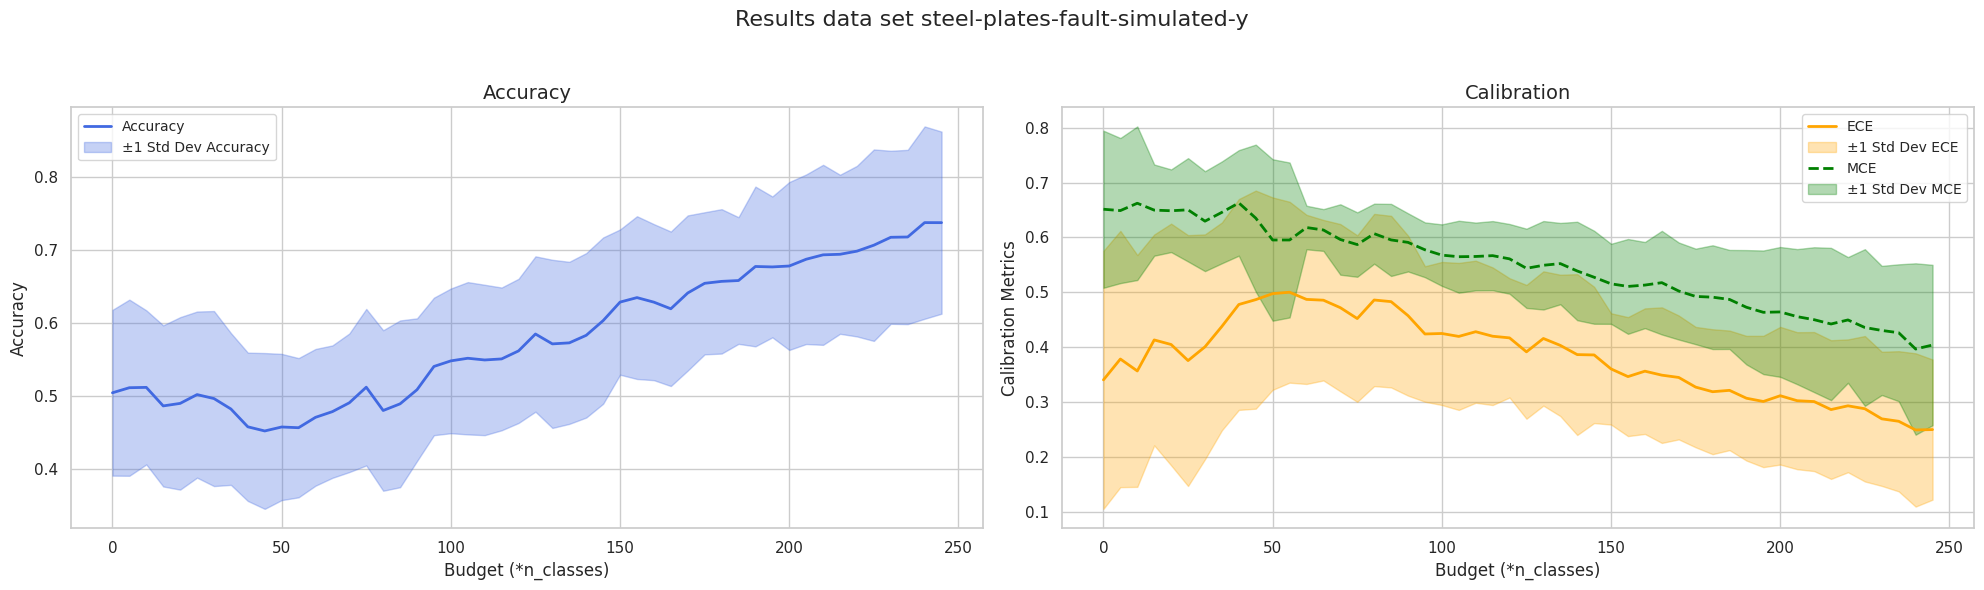

Data set: phoneme-simulated-y. Simulations: 20
Annotator selection: fixed
Accuracy:0.668. ECE: 0.209. MCE: 0.527
Annotations per instance: 1.0. Max annotations: 1.0


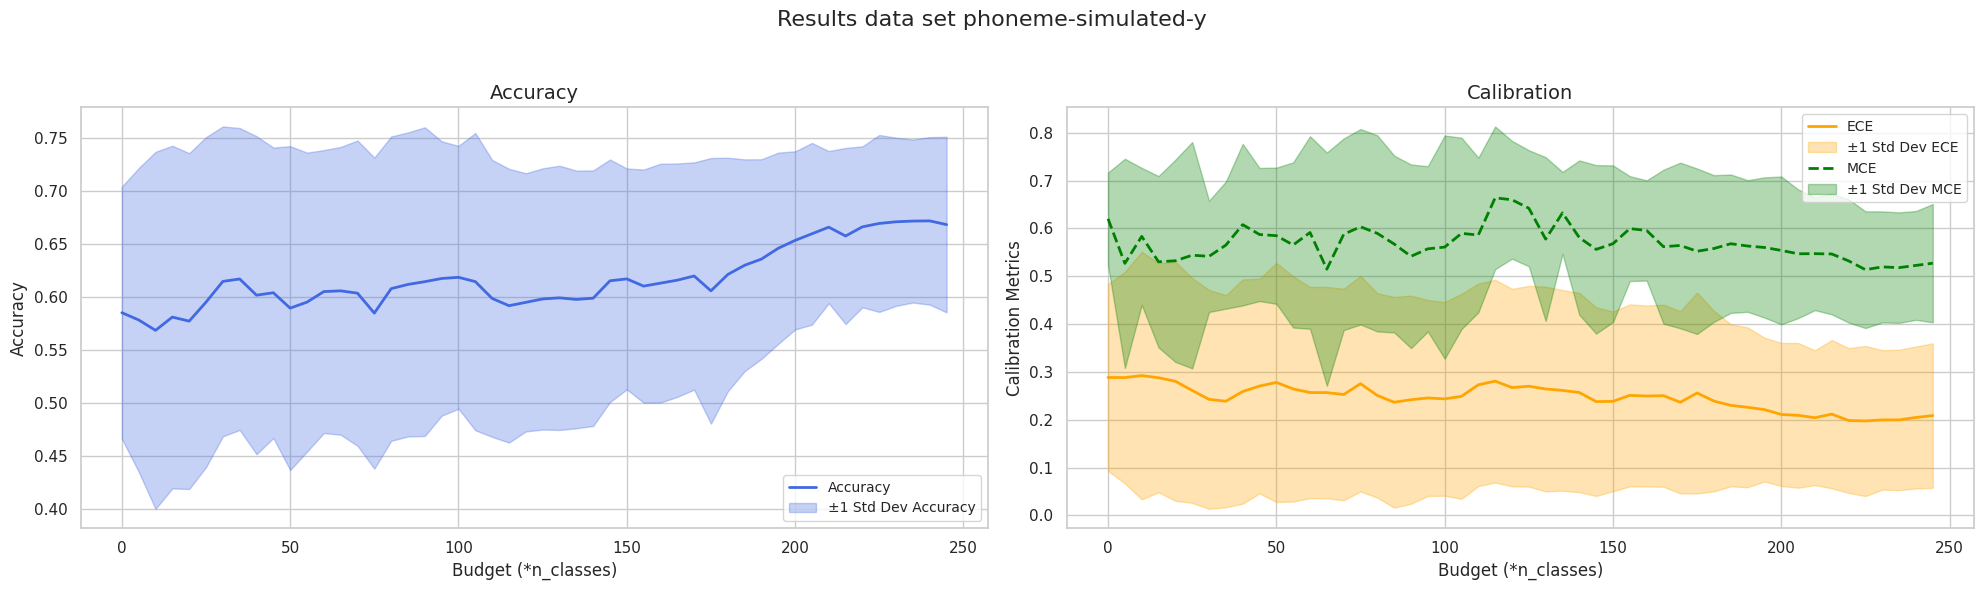

Data set: phoneme-simulated-y. Simulations: 20
Annotator selection: random
Accuracy:0.77. ECE: 0.111. MCE: 0.393
Annotations per instance: 1.278. Max annotations: 4.25


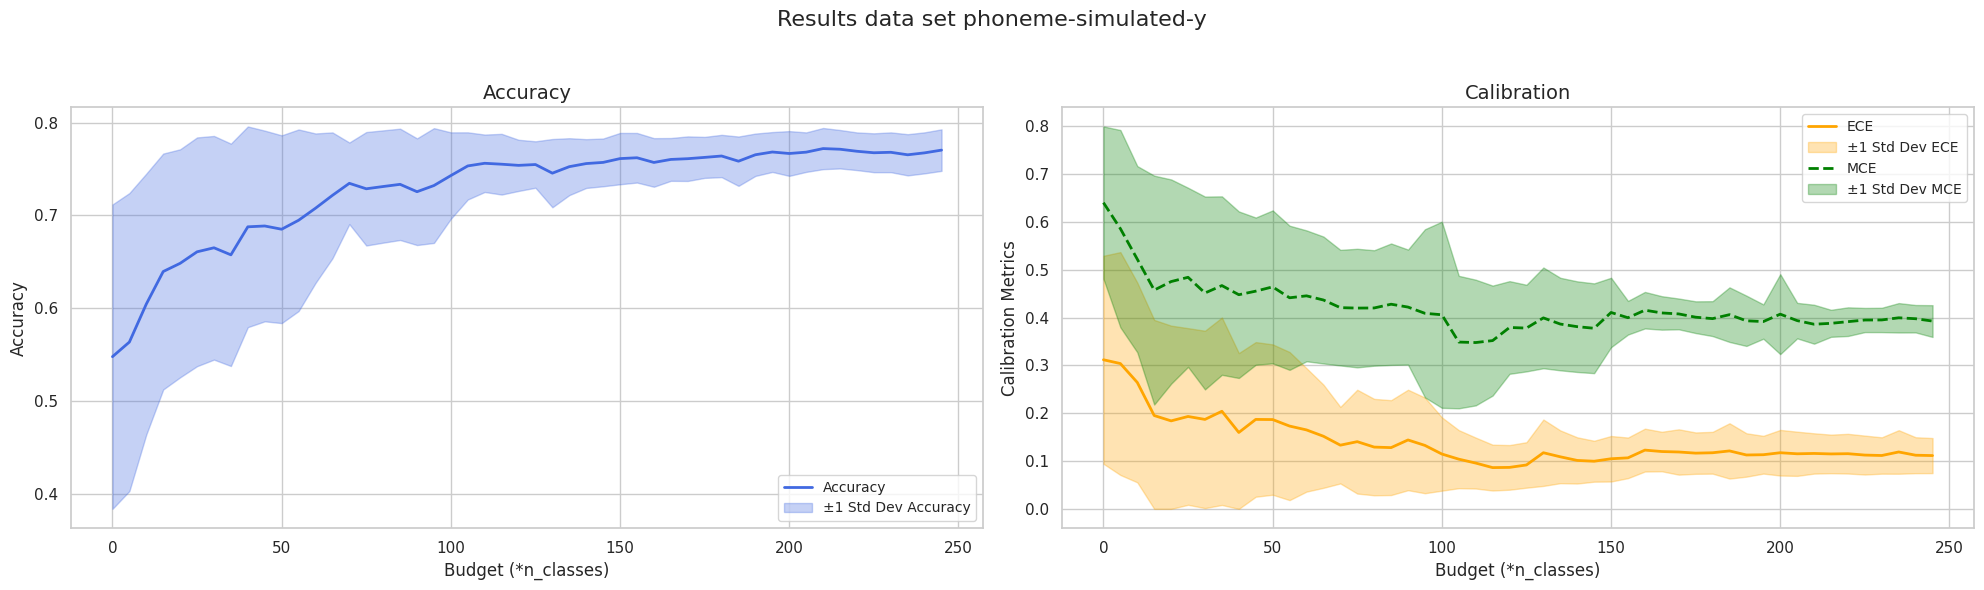

Data set: phoneme-simulated-y. Simulations: 20
Annotator selection: epm
Accuracy:0.75. ECE: 0.15. MCE: 0.439
Annotations per instance: 1.233. Max annotations: 4.1


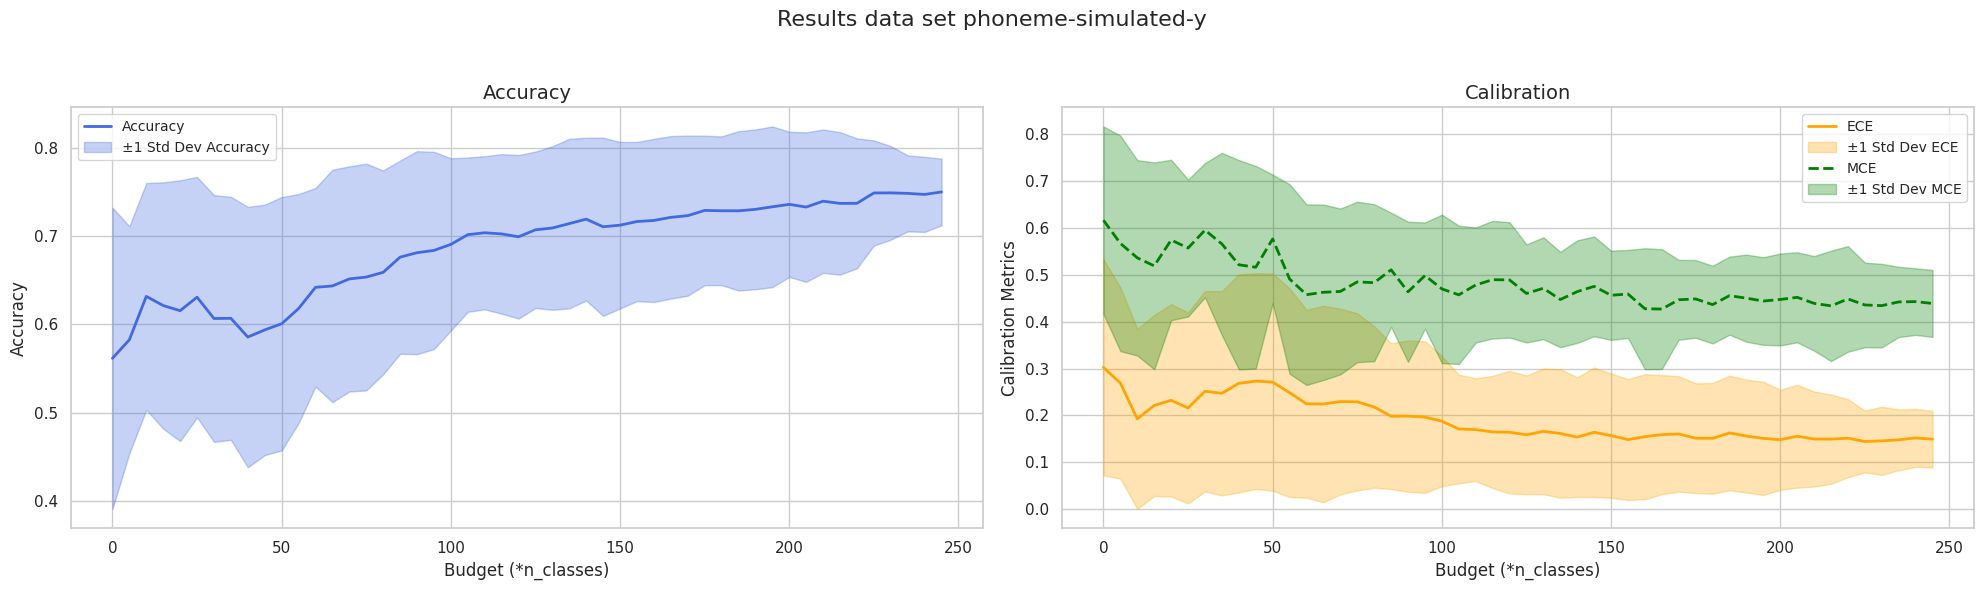

In [43]:
data_set_names = ['breast-cancer-wisconsin', 'biodegradation', 'banknote', 'steel-plates-fault', 'phoneme']
simulation_type = 'y' # e {o (uniform performance values), x (instance dependent performance), y (class dependent performance)}
n_simulations = 20

seeds = np.arange(n_simulations)
nbudget = 5

relabel = False
annotator = 0
fixed = partial(select_fixed_annotator, annotator=0)
rand = select_random_annotator
epm = select_annotator_epm
configs = {'fixed':(fixed, False), 'random':(rand, True), 'epm':(epm, True)}

name = 'biodegradation'

for name in data_set_names:
	for cname, config in configs.items():

		data_set_name = f'{name}-simulated-{simulation_type}'
		print(f'Data set: {data_set_name}. Simulations: {n_simulations}')
		print(f'Annotator selection: {cname}')
		
		annotator_selection, relabel = config
		# classifier = GaussianNB
		classifier = partial(PWC, metric='rbf')

		results = []

		for seed in seeds:
			with warnings.catch_warnings():
				warnings.filterwarnings("ignore", category= RuntimeWarning)
				warnings.filterwarnings("ignore", category= FutureWarning)
				res = run_experiment(data_set_name=data_set_name, seed=1, classifier=partial(PWC, metric='rbf'), 
							nbudget=5, query_strategy=margin_qs, annnotator_selection=annotator_selection, 
							verbose=False, relabel=relabel
							)
			results.append(res)

		acc = [x['accuracies'] for x in results]
		ece = [x['ece'] for x in results]
		mce = [x['mce'] for x in results]
		api = [x['api'] for x in results]
		max_annotations = [x['max_annotations'] for x in results]

		last_means = [np.mean(l, axis=0)[-1].round(3) for l in [acc, ece, mce, api, max_annotations]]
		print(f'Accuracy:{last_means[0]}. ECE: {last_means[1]}. MCE: {last_means[2]}')
		print(f'Annotations per instance: {last_means[3]}. Max annotations: {last_means[4]}')
		x = np.arange(len(acc[0])) * nbudget
		sns.set_theme(style='whitegrid')

		# Create subplots
		fig, axes = plt.subplots(1, 2, figsize=(20, 6))

		# Plot accuracy on the left
		plot_mean_std(axes[0], acc, x, label="Accuracy", color="royalblue")
		axes[0].set_title("Accuracy", fontsize=14)
		axes[0].set_xlabel("Budget (*n_classes)", fontsize=12)
		axes[0].set_ylabel("Accuracy", fontsize=12)
		axes[0].legend(fontsize=10)

		# Plot ECE and MCE on the right
		plot_mean_std(axes[1], ece, x, label="ECE", color="orange")
		plot_mean_std(axes[1], mce, x, label="MCE", color="green", linestyle='--')
		axes[1].set_title("Calibration", fontsize=14)
		axes[1].set_xlabel("Budget (*n_classes)", fontsize=12)
		axes[1].set_ylabel("Calibration Metrics", fontsize=12)
		axes[1].legend(fontsize=10)

		# Set the overall title
		fig.suptitle(f"Results data set {data_set_name}", fontsize=16)

		# Adjust layout
		plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the overall title

		# Show the plot
		plt.show()